In [1]:
import numpy as np
import cv2
from matplotlib.pyplot import plot
from pathlib import Path
from itertools import combinations
import utils

In [2]:
DATA_ROOT_PATH = Path('data')
IMG_PATH =  DATA_ROOT_PATH / 'q2b.png'
ANNOTATIONS_PATH = DATA_ROOT_PATH / 'q2' / 'q2b.npy'

COLORS = [(0, 255, 0), (0, 255, 255), (255, 255, 0), (255, 0, 0), (0, 0, 255)]

In [3]:
image = utils.load_image(IMG_PATH)

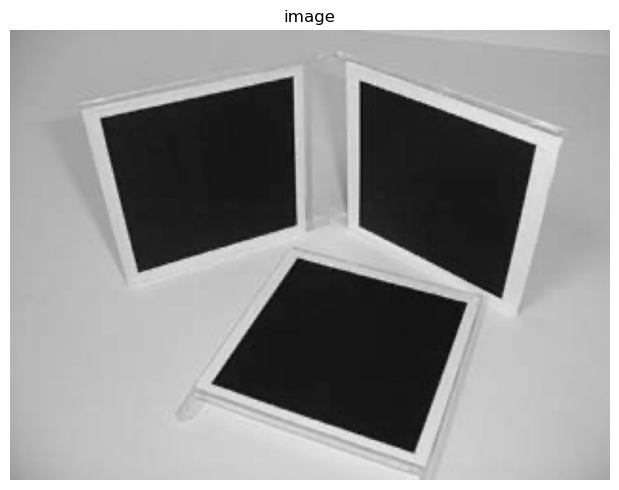

In [4]:
utils.show_images([image], ['image'])

In [5]:
annotations = np.load(ANNOTATIONS_PATH).astype(np.int64)

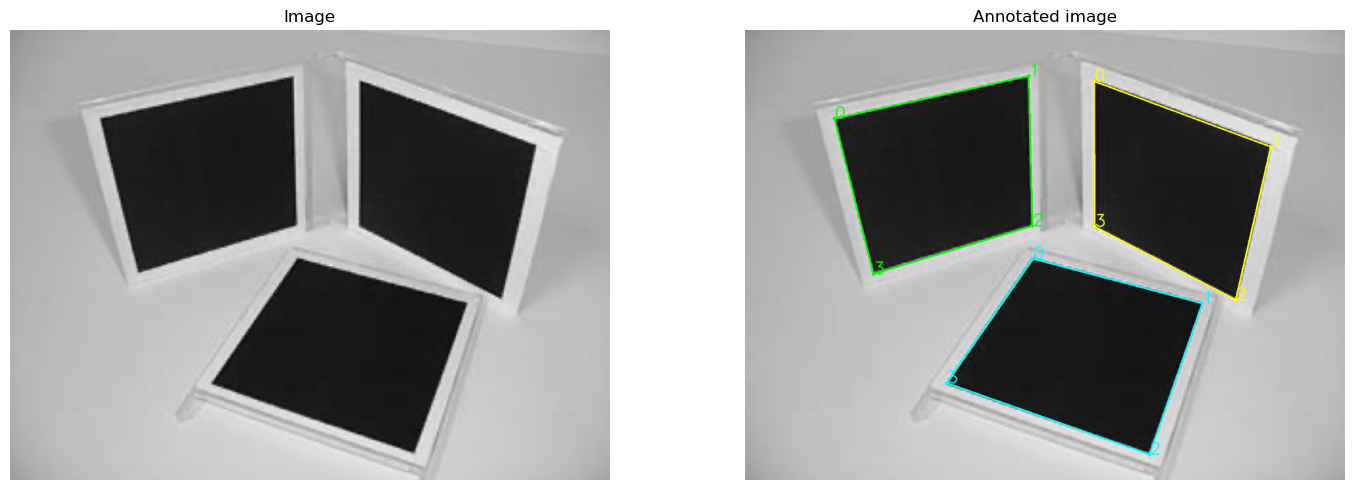

In [6]:
annotated_img = image.copy()

for i in range(annotations.shape[0]):
    COLOR = COLORS[i]
    square = annotations[i]
    for j in range(square.shape[0]):
        x, y = square[j]
        cv2.circle(annotated_img, (x, y), 3, COLOR, -1)
        cv2.putText(
            annotated_img, str(j), (x, y), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR, 1, cv2.LINE_AA
        )
        cv2.line(annotated_img, square[j], square[(j + 1) % 4], COLOR, 2)
    
utils.show_images([image, annotated_img], ['Image', 'Annotated image'])

In [7]:
print(annotations)
annotations.shape

[[[152 151]
  [484  78]
  [490 334]
  [219 416]]

 [[595  87]
  [897 199]
  [837 460]
  [596 335]]

 [[491 390]
  [780 466]
  [690 724]
  [344 602]]]


(3, 4, 2)

In [8]:
conic_points = [[0, 0], [1, 0], [1, 1], [0, 1]]

In [9]:
# Constract the A matrix AH = 0
H_list = []
for points in annotations:
    A = []
    i = 0
    for point in points:
        u = conic_points[i][0]
        v = conic_points[i][1]
        i += 1

        x = point[0]
        y = point[1]

        equ1 = [u, v, 1, 0, 0, 0, -u*x, -v*x, -x]
        equ2 = [0, 0, 0, u, v, 1, -u*y, -v*y, -y]
    
        A.append(equ1)
        A.append(equ2)
            
    _, _, vt = np.linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    H = H / H[2, 2]
    H_list.append(H)

for h in H_list:
    print(h)

[[ 3.83546402e+02  1.15778811e+02  1.52000000e+02]
 [-6.46929352e+01  3.57657468e+02  1.51000000e+02]
 [ 1.06500830e-01  2.22734299e-01  1.00000000e+00]]
[[ 1.64929135e+02  1.29180509e+02  5.95000000e+02]
 [ 8.15907444e+01  3.20047769e+02  8.70000000e+01]
 [-1.52810329e-01  2.15067968e-01  1.00000000e+00]]
[[ 2.19269332e+02 -2.11669859e+02  4.91000000e+02]
 [ 3.43403958e+01  9.88277472e+01  3.90000000e+02]
 [-8.93982922e-02 -1.87993775e-01  1.00000000e+00]]


In [10]:
def get_v(h_i, h_j):
    """
    Calculates the 1x6 vector v_ij such that h_i.T * w * h_j = v_ij * b
    where b = [w11, w12, w22, w13, w23, w33].T
    h_i and h_j are column vectors of H.
    """
    # Using indices 0, 1, 2 for x, y, z (or 1, 2, 3 in math notation)
    return np.array([
        h_i[0]*h_j[0],                          # w11
        h_i[0]*h_j[1] + h_i[1]*h_j[0],          # w12
        h_i[1]*h_j[1],                          # w22
        h_i[2]*h_j[0] + h_i[0]*h_j[2],          # w13
        h_i[2]*h_j[1] + h_i[1]*h_j[2],          # w23
        h_i[2]*h_j[2]                           # w33
    ])

V_matrix = []

for H in H_list:
    # Extract the first two columns of H
    h1 = H[:, 0]
    h2 = H[:, 1]
    
    # Calculate the v vectors
    v12 = get_v(h1, h2)
    v11 = get_v(h1, h1)
    v22 = get_v(h2, h2)
    
    # Equation 1: h1.T * w * h2 = 0  ->  v12 * b = 0
    V_matrix.append(v12)
    
    # Equation 2: h1.T * w * h1 = h2.T * w * h2  ->  (v11 - v22) * b = 0
    V_matrix.append(v11 - v22)

# Solve V*b = 0 using SVD to find b (which represents omega)
_, _, vt_omega = np.linalg.svd(V_matrix)
b = vt_omega[-1]

# Reconstruct the symmetric matrix omega (w)
# b = [w11, w12, w22, w13, w23, w33]
w11, w12, w22, w13, w23, w33 = b
W = np.array([
    [w11, w12, w13],
    [w12, w22, w23],
    [w13, w23, w33]
])

W = W / W[2, 2]

In [11]:
W

array([[ 6.19018337e-07,  7.75181184e-09, -3.25018400e-04],
       [ 7.75181184e-09,  6.25408856e-07, -2.55786031e-04],
       [-3.25018400e-04, -2.55786031e-04,  1.00000000e+00]])

In [12]:
L = np.linalg.cholesky(W)
K = np.linalg.inv(L).T
K = K / K[2, 2]
K

array([[ 1.08447642e+03, -1.35121131e+01,  5.20013594e+02],
       [-0.00000000e+00,  1.07900526e+03,  4.02544642e+02],
       [-0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])